# CARE via ZeroCost project

Both for segmentation and denoising, in the previous chapters we always used models that were already available and easy to load in the necessary software. Sometimes we however need to train a *new* model specifically for our data. In that case what we end up is a file containing the trained model and we need to import it using the correct framework to use it for inference. 

## Content Aware Restoration

In this chapter we will train and use a model for denoising. We use here the [CARE](https://csbdeep.bioimagecomputing.com/tools/care/) model which perform content-aware image restoration with matching image pairs. The idea is the following: 

1. First, during acquisition, for each location that we image, we capture two images: a good one and a bad one. In the context of fluorescence microscopy, this means taking an image at high illumination and one at low illumination.

2. Now we can define a Deep Learning network that takes an image as input and gives an image as output. We train the network using our pairs of images, the "good" image being the *target*. In other words we try to optimize our network so that it tries **to transform bad images into good ones**. Essentially, during trainign the network will learn the noise structure.

3. Once our model is trained, we can use it for inference: we transform new "bad" images into "good" ones. Note that the image we want to improve, needs to be of same "nature" as those used for training. For example if we trained on images with spots, we can't use our model to denoise actin filaments.

Still in the frame of fluorescence microscopy, the big advantage of such as method is that in principle it allows one to limit the damage inflicated by high illumination and still get images of good enough quality to be analyzed-

## Dataset

As an example, we take here a dataset published a long [this article](https://academic.oup.com/gigascience/article/10/5/giab032/6269106#246827577 
). You can find all data [here](http://gigadb.org/dataset/view/id/100888). In there authors acquired images of actin filaments a low and high signal to noise ratio to test this kind of denoising method. Here are two representative images:

In [1]:
import skimage
import numpy as np
import tensorflow as tf
from microfilm.microplot import microshow
from microfilm.microplot import Micropanel

In [2]:
im_low = skimage.io.imread('../data/actin_60_example/image99_low.tiff')
im_high = skimage.io.imread('../data/actin_60_example/image99_high.tiff')

Note that we use here two different contrast settings, as otherwise one of the images is not visible.

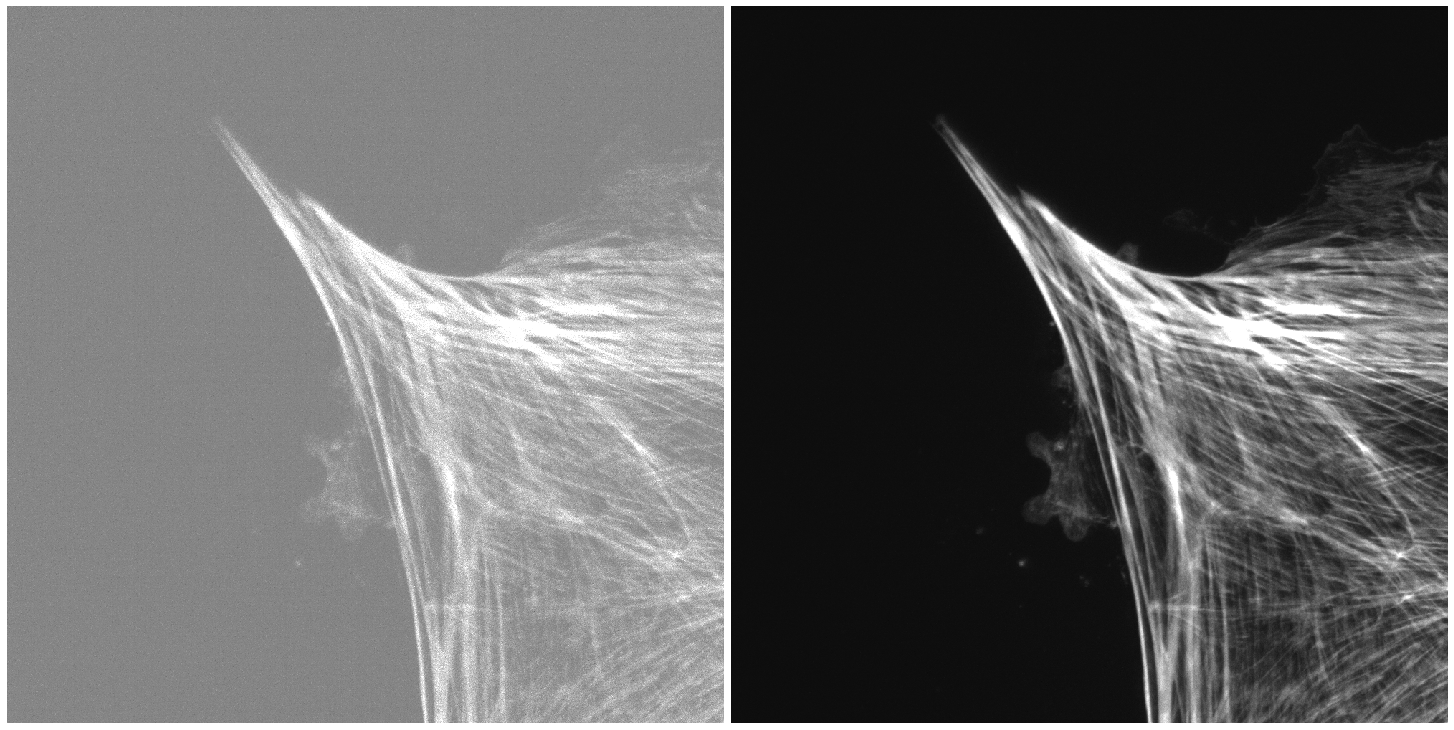

In [3]:
panel = Micropanel(1,2,figscaling=10)
panel.add_element([0,0], microshow(im_low[0:1000,0:1000], limits=[0,200], ax=panel.ax[0,0]))
panel.add_element([0,1], microshow(im_high[0:1000,0:1000], limits=[0,2000], ax=panel.ax[0,1]))

## ZeroCost training

With all your training data, you can now head to the ZeroCostDL4Mic project, specifically to the [section about denoising](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki#denoising-and-image-restoration-networks). You will find there a few links, and in particular one leading you to a Colab notebooks that will guide you step by step through the process.

In [4]:
from IPython.display import Image
Image(url='../illustrations/zero_cost.png',width=700)

At the end you will obtain a folder containing your trained model that you can re-import in a notebook like here or even directly in Fiji in some cases.

## Re-importing the model

How to re-import a model depends on the package used for training. In the case of CARE we can instantiate a model by pointing to the folder containng the relevant files:

In [5]:
from csbdeep.models import CARE

model = CARE(config=None, name='model2022', basedir='../data/micpy/')

Metal device set to: Apple M1 Pro


2022-07-09 23:14:01.976980: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-09 23:14:01.977298: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Loading network weights from 'weights_best.h5'.


Then we can use the ```predict``` method to denoise the image with the network:

In [6]:
denoised = model.predict(im_low, axes = 'YX')

2022-07-09 23:14:04.857004: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-09 23:14:04.935504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


Let's check how it has improved:

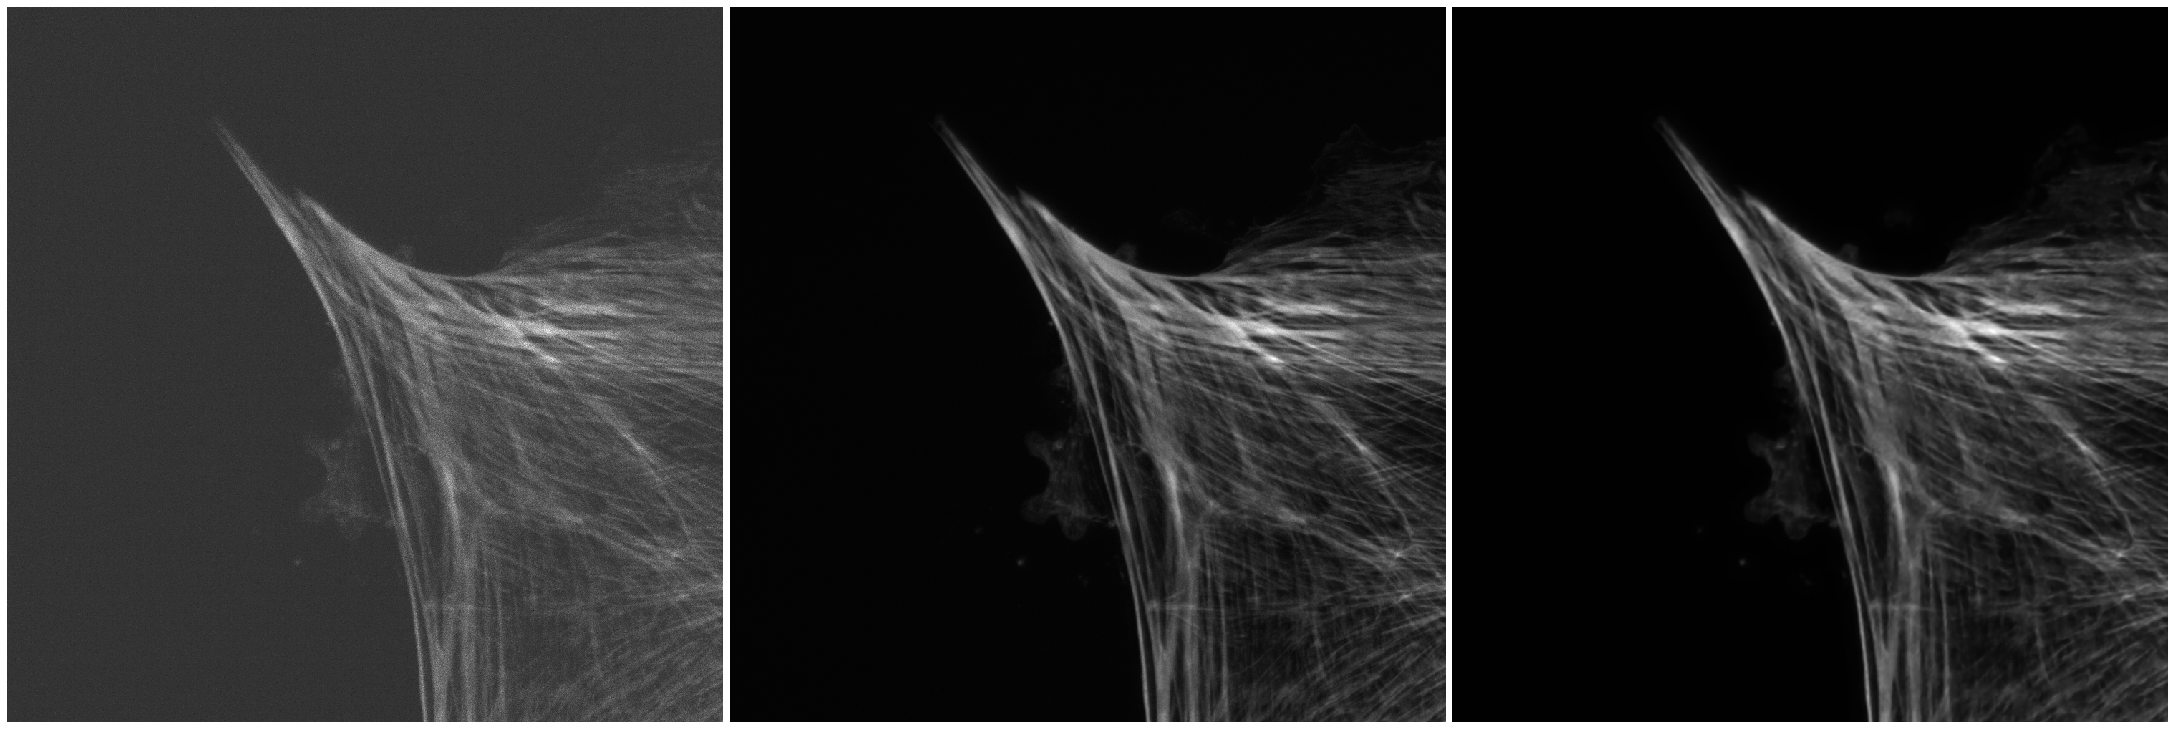

In [7]:
panel = Micropanel(1,3,figscaling=10)
panel.add_element([0,0], microshow(im_low[0:1000,0:1000], ax=panel.ax[0,0]))
panel.add_element([0,1], microshow(im_high[0:1000,0:1000], ax=panel.ax[0,1]))
panel.add_element([0,2], microshow(denoised[0:1000,0:1000], ax=panel.ax[0,2]))